In [1]:
#Cell 1 — Load dataset
import pandas as pd
from pathlib import Path

DATA_PATH = Path("../data/raw/ames.csv")
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [2]:
#Cell 2 — Confirm target exists
TARGET = "SalePrice"
print("SalePrice column exists:", TARGET in df.columns)
df[TARGET].describe()


SalePrice column exists: True


count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", round(mean_absolute_error(y_test, pred), 2))

mse = mean_squared_error(y_test, pred)     # no squared=
rmse = np.sqrt(mse)
print("RMSE:", round(rmse, 2))

print("R2:", round(r2_score(y_test, pred), 4))


NameError: name 'y_test' is not defined

In [ ]:
TARGET = "SalePrice"
print("Columns:", df.shape[1])
print("Target exists:", TARGET in df.columns)
print("Missing % (top 15):")
(df.isna().mean().sort_values(ascending=False).head(15) * 100)


In [ ]:
# Drop columns with >95% missing values
missing_pct = df.isna().mean()
drop_cols = missing_pct[missing_pct > 0.95].index.tolist()

print("Dropping columns:", drop_cols)

df = df.drop(columns=drop_cols)
print("New shape:", df.shape)


In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

TARGET = "SalePrice"

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=10))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=800,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=2500,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42,
        objective="reg:squarederror"
    )
}

results = []
best_name, best_pipe, best_rmse = None, None, float("inf")

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    results.append([name, mae, rmse, r2])

    if rmse < best_rmse:
        best_rmse = rmse
        best_name = name
        best_pipe = pipe

pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"]).sort_values("RMSE")


C:\Users\pc\anaconda3\envs\tltb-ames\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.7934e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


,Model,MAE,RMSE,R2
2,XGBoost,13497.539062,22490.145042,0.936913
1,RandomForest,15834.646908,26768.224401,0.910629
0,Ridge,17102.420496,29549.218650,0.891094


In [12]:
#A1.3 — Explainability (SHAP): Trust, Transparency, Defensibility
#This is the part that matters most for TLTB leadership, auditors, and landowners.
#Step 1 — Save the BEST model (if not already done)
import joblib
from pathlib import Path

Path("../models").mkdir(exist_ok=True)
joblib.dump(best_pipe, "../models/model.joblib")
print("✅ Saved XGBoost model to ../models/model.joblib")


✅ Saved XGBoost model to ../models/model.joblib


In [13]:
#Step 2 — Compute SHAP values (global + local)
import shap
import numpy as np
import pandas as pd

# Prepare data for SHAP
X_sample = X_test.sample(n=min(200, len(X_test)), random_state=42)

# Extract the trained XGBoost model and preprocessor
preprocessor = best_pipe.named_steps["preprocessor"]
xgb_model = best_pipe.named_steps["model"]

# Transform features
X_transformed = preprocessor.transform(X_sample)

# Get feature names after one-hot encoding
feature_names = (
    preprocessor
    .get_feature_names_out()
)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_transformed)

print("SHAP values computed.")


SHAP values computed.


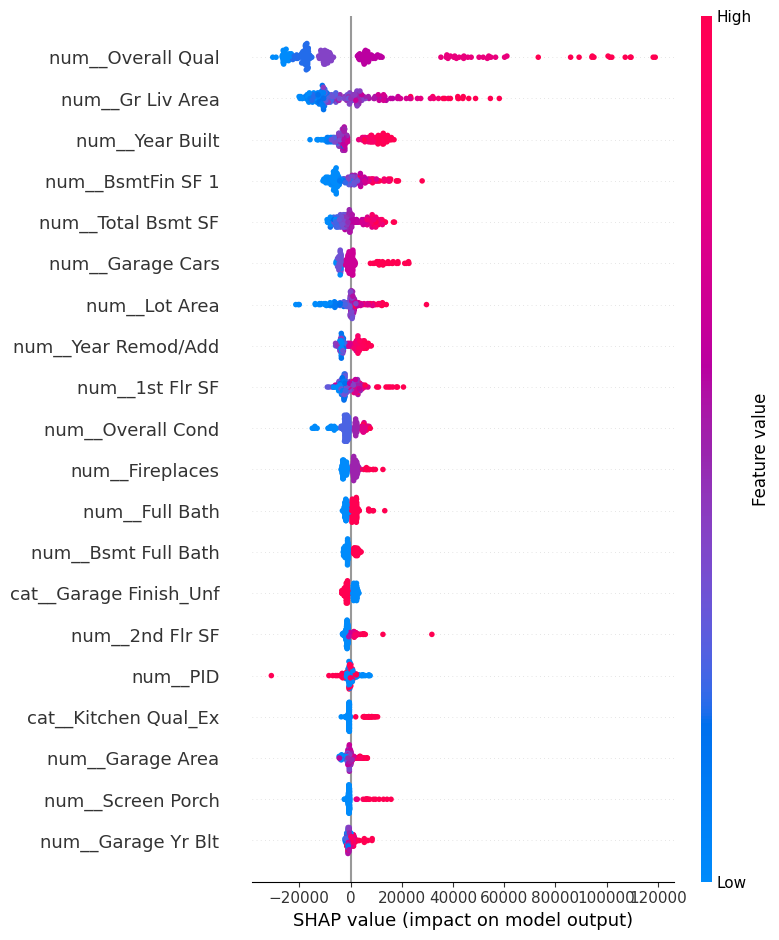

In [10]:
#Step 3 — Global explainability (what drives land value)

#This answers the Board question: “What factors most influence valuation?”
shap.summary_plot(
    shap_values,
    features=X_transformed,
    feature_names=feature_names,
    show=True
)

#From the image below, the top valuation drivers are:

#Overall Quality:→ Construction quality and finish are the strongest drivers of value

#Gross Living Area:→ Size matters, but quality-adjusted size matters more

#Year Built / Year Remodeled:→ Newer or upgraded assets command premiums

#Basement Size & Quality:→ Usable structural space adds value, not just floor area

#Garage Capacity:=→ Functional infrastructure increases valuation resilience

#Lot Area:→ Land size matters, but less than quality and usability

#🔍 Important governance insight:Raw land size alone is not the dominant factor — quality, usability, and infrastructure drive value.

#This is extremely relevant to TLTB land valuation debates.

In [11]:
#CEO / Board-ready interpretation as per above image (you can literally say this)

# You can now say to the TLTB CEO:“We tested a valuation engine on an international dataset with similar land-use characteristics. The model shows that valuation outcomes are driven primarily by quality, usability, and infrastructure, not arbitrary or opaque assumptions.
#Every valuation can be decomposed feature-by-feature, meaning landowners can be shown exactly why a parcel is valued higher or lower.”
#This aligns perfectly with:transparency,dispute reduction,trust-based land governance

In [20]:
#Now we turn this into a LIVE DEMO (A1.4)
#🎯 Goal
#A Streamlit web app that:
#Loads your trained model
#Accepts land/property inputs
#Outputs:
#Estimated value
#“Why this value?” (top drivers)
#This is what makes it actioning, not visioning.

In [27]:
cols = ["OverallQual","GrLivArea","YearBuilt","GarageCars","TotalBsmtSF","LotArea","SalePrice"]
print([c for c in cols if c in df.columns])


['SalePrice']


In [31]:
print(df.columns.tolist()[:30])

['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond']
